# Prevendo Customer Churn em Operadoras de Telecom

## Importando as bibliotecas necessárias

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd #importando o pacote pandas
import numpy as np #pacote numérico numpy
import time
import pickle

#visualização de dados
from matplotlib import pyplot as plt
import seaborn as sns #pacote seaborn para construção de gráficos

#SMOTE
from imblearn.over_sampling import SMOTE #importando a função SMOTE

#SKLEARN
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler # importando função para a Padronização dos dados

#Importando pacotes de Tuning
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import GridSearchCV

#Importando os algoritmos de classificação
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

## Criando uma função para explorar os dados

In [4]:
# Criando uma função que retorna um dataframe de descrição de dados (tal qual a função describe do pacote explore do R)
def explore_describe(df):
    df_out = pd.DataFrame(columns = ['variable','type','na' ,'na_pct' ,'unique','min', 'quat25','median','mean', \
                                     'quat75','max','std','skewness','kurtosis','media_desvio'])
    df_out['variable'] = df.columns
    df_out['type'] = df.dtypes.values
    df_out['na'] = [len(df[coluna]) - df[coluna].count() for coluna in df.columns]
    df_out['na_pct'] = df_out.na/len(df_out.na)*100
    df_out['unique'] = [len(df[coluna].unique()) for coluna in df.columns]
    df_out['min']  = [min(df[coluna]) if 'int' in str(df[coluna].dtype) or 'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['mean'] = [round(df[coluna].mean(),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['max']  = [max(df[coluna]) if 'int' in str(df[coluna].dtype) or 'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['std'] = [round(df[coluna].std(),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['quat25'] = [round(df[coluna].quantile(0.25),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['quat75'] = [round(df[coluna].quantile(0.75),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['median'] = [round(df[coluna].quantile(0.5),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['skewness'] = [df[coluna].skew() if 'int' in str(df[coluna].dtype) or \
                          'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['kurtosis'] = [df[coluna].kurt() if 'int' in str(df[coluna].dtype) or \
                          'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['media_desvio'] = [round(df[coluna].mean()/df[coluna].std(),2) if 'int' in str(df[coluna].dtype) or \
                                'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    return(df_out)


## Importando o dataset de treino

In [5]:
treino = pd.read_csv("projeto4_telecom_treino.csv",header=0)
treino

,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,3329,AZ,192,area_code_415,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,no
3329,3330,WV,68,area_code_415,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,no
3330,3331,RI,28,area_code_510,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,no
3331,3332,CT,184,area_code_510,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,no


In [6]:
#Primeira coluna contém o indice de alguma exportação do Python. Dessa forma, vamos remover essa coluna
treino = treino.loc[:,'state':]
treino

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,area_code_415,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,no
3329,WV,68,area_code_415,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,no
3330,RI,28,area_code_510,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,no
3331,CT,184,area_code_510,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,no


## Análise exploratória dos dados

Como não há um dicionário de dados, vamos, a partir do cabeçalho, definir o que seja cada varíavel:
1. __state__: (categórica) Estado do cliente
2. __account_length__: (inteiro) o período, (provavelmente em dias), que a pessoa se tornou cliente
3. __area_code__: (categórica) codigo da área do cliente
4. __international_plan__: (booleana) o cliente possui um plano internacional?
5. __voice_mail_plan__: (booleana) o cliente possui plano de mensagem de voz?
6. __number_vmail.messages__: (inteiro) o número de mensagens de voz em sua caixa de mensagem
7. __total_day_minutes__:
8. __total_day_calls__:
9. __total_day_charge__:
10. __total_eve_minutes__:
11. __total_eve_calls__:
12. __total_eve_charge__:
13. __total_night_minutes__:
14. __total_night_calls__:
15. __total_night_charge__:
16. __total_intl_minutes__:
17. __total_intl_calls__:
18. __total_intl_charge__:
19. __number_customer_service_calls__:
20. __churn__: (booleana) a pessoa deixou ou não de ser cliente


Algumas anotações a respeito da descrição dos dados abaixo:
- As variáveis *number_customer_service_calls* e *number_vmail_messages* parecem ser as únicas variáveis numéricas que não seguem uma distribuição normal (<font color=blue> Verificar comportamento em pairplot das variáveis numéricas </font>

In [7]:
explore_describe(treino)

,variable,type,na,na_pct,unique,min,quat25,median,mean,quat75,max,std,skewness,kurtosis,media_desvio
0,state,object,0,0.0,51,-,-,-,-,-,-,-,-,-,-
1,account_length,int64,0,0.0,212,1,74,101,101.06,127,243,39.82,0.0966063,-0.107836,2.54
2,area_code,object,0,0.0,3,-,-,-,-,-,-,-,-,-,-
3,international_plan,object,0,0.0,2,-,-,-,-,-,-,-,-,-,-
4,voice_mail_plan,object,0,0.0,2,-,-,-,-,-,-,-,-,-,-
5,number_vmail_messages,int64,0,0.0,46,0,0,0,8.1,20,51,13.69,1.26482,-0.0511285,0.59
6,total_day_minutes,float64,0,0.0,1667,0,143.7,179.4,179.78,216.4,350.8,54.47,-0.0290771,-0.0199404,3.3
7,total_day_calls,int64,0,0.0,119,0,87,101,100.44,114,165,20.07,-0.111787,0.243182,5
8,total_day_charge,float64,0,0.0,1667,0,24.43,30.5,30.56,36.79,59.64,9.26,-0.0290833,-0.0198118,3.3
9,total_eve_minutes,float64,0,0.0,1611,0,166.6,201.4,200.98,235.3,363.7,50.71,-0.0238775,0.0256298,3.96


Há um desbalanceamento de variáveis, por isso, há necessidade de aplica <font color = blue> SMOTE </font>

In [8]:
#Verificando a proporção das classes
contagem = treino.groupby('churn')[['churn']].count()
contagem.assign(percent = 100*contagem.churn/sum(contagem.churn))

,churn,percent
churn,,
no,2850,85.508551
yes,483,14.491449


Algumas anotações a respeito da descrição dos dados abaixo:
- Realmente as variáveis descritas anteriormente parecem seguir uma distribuição normal, exceto *number_vmail_messages* e *number_customer_service_calls*. Pode-se notar que 

In [43]:
#Pela quantidade de variaveis, vamos apenas realizar um mapeamento das variáveis, para facilitar a identificação no pairplot
mapeamento = {}
for i in range(0,len(treino.columns)-1):
    mapeamento[treino.columns[i]] = i
mapeamento

{'state': 0,
 'account_length': 1,
 'area_code': 2,
 'international_plan': 3,
 'voice_mail_plan': 4,
 'number_vmail_messages': 5,
 'total_day_minutes': 6,
 'total_day_calls': 7,
 'total_day_charge': 8,
 'total_eve_minutes': 9,
 'total_eve_calls': 10,
 'total_eve_charge': 11,
 'total_night_minutes': 12,
 'total_night_calls': 13,
 'total_night_charge': 14,
 'total_intl_minutes': 15,
 'total_intl_calls': 16,
 'total_intl_charge': 17,
 'number_customer_service_calls': 18}

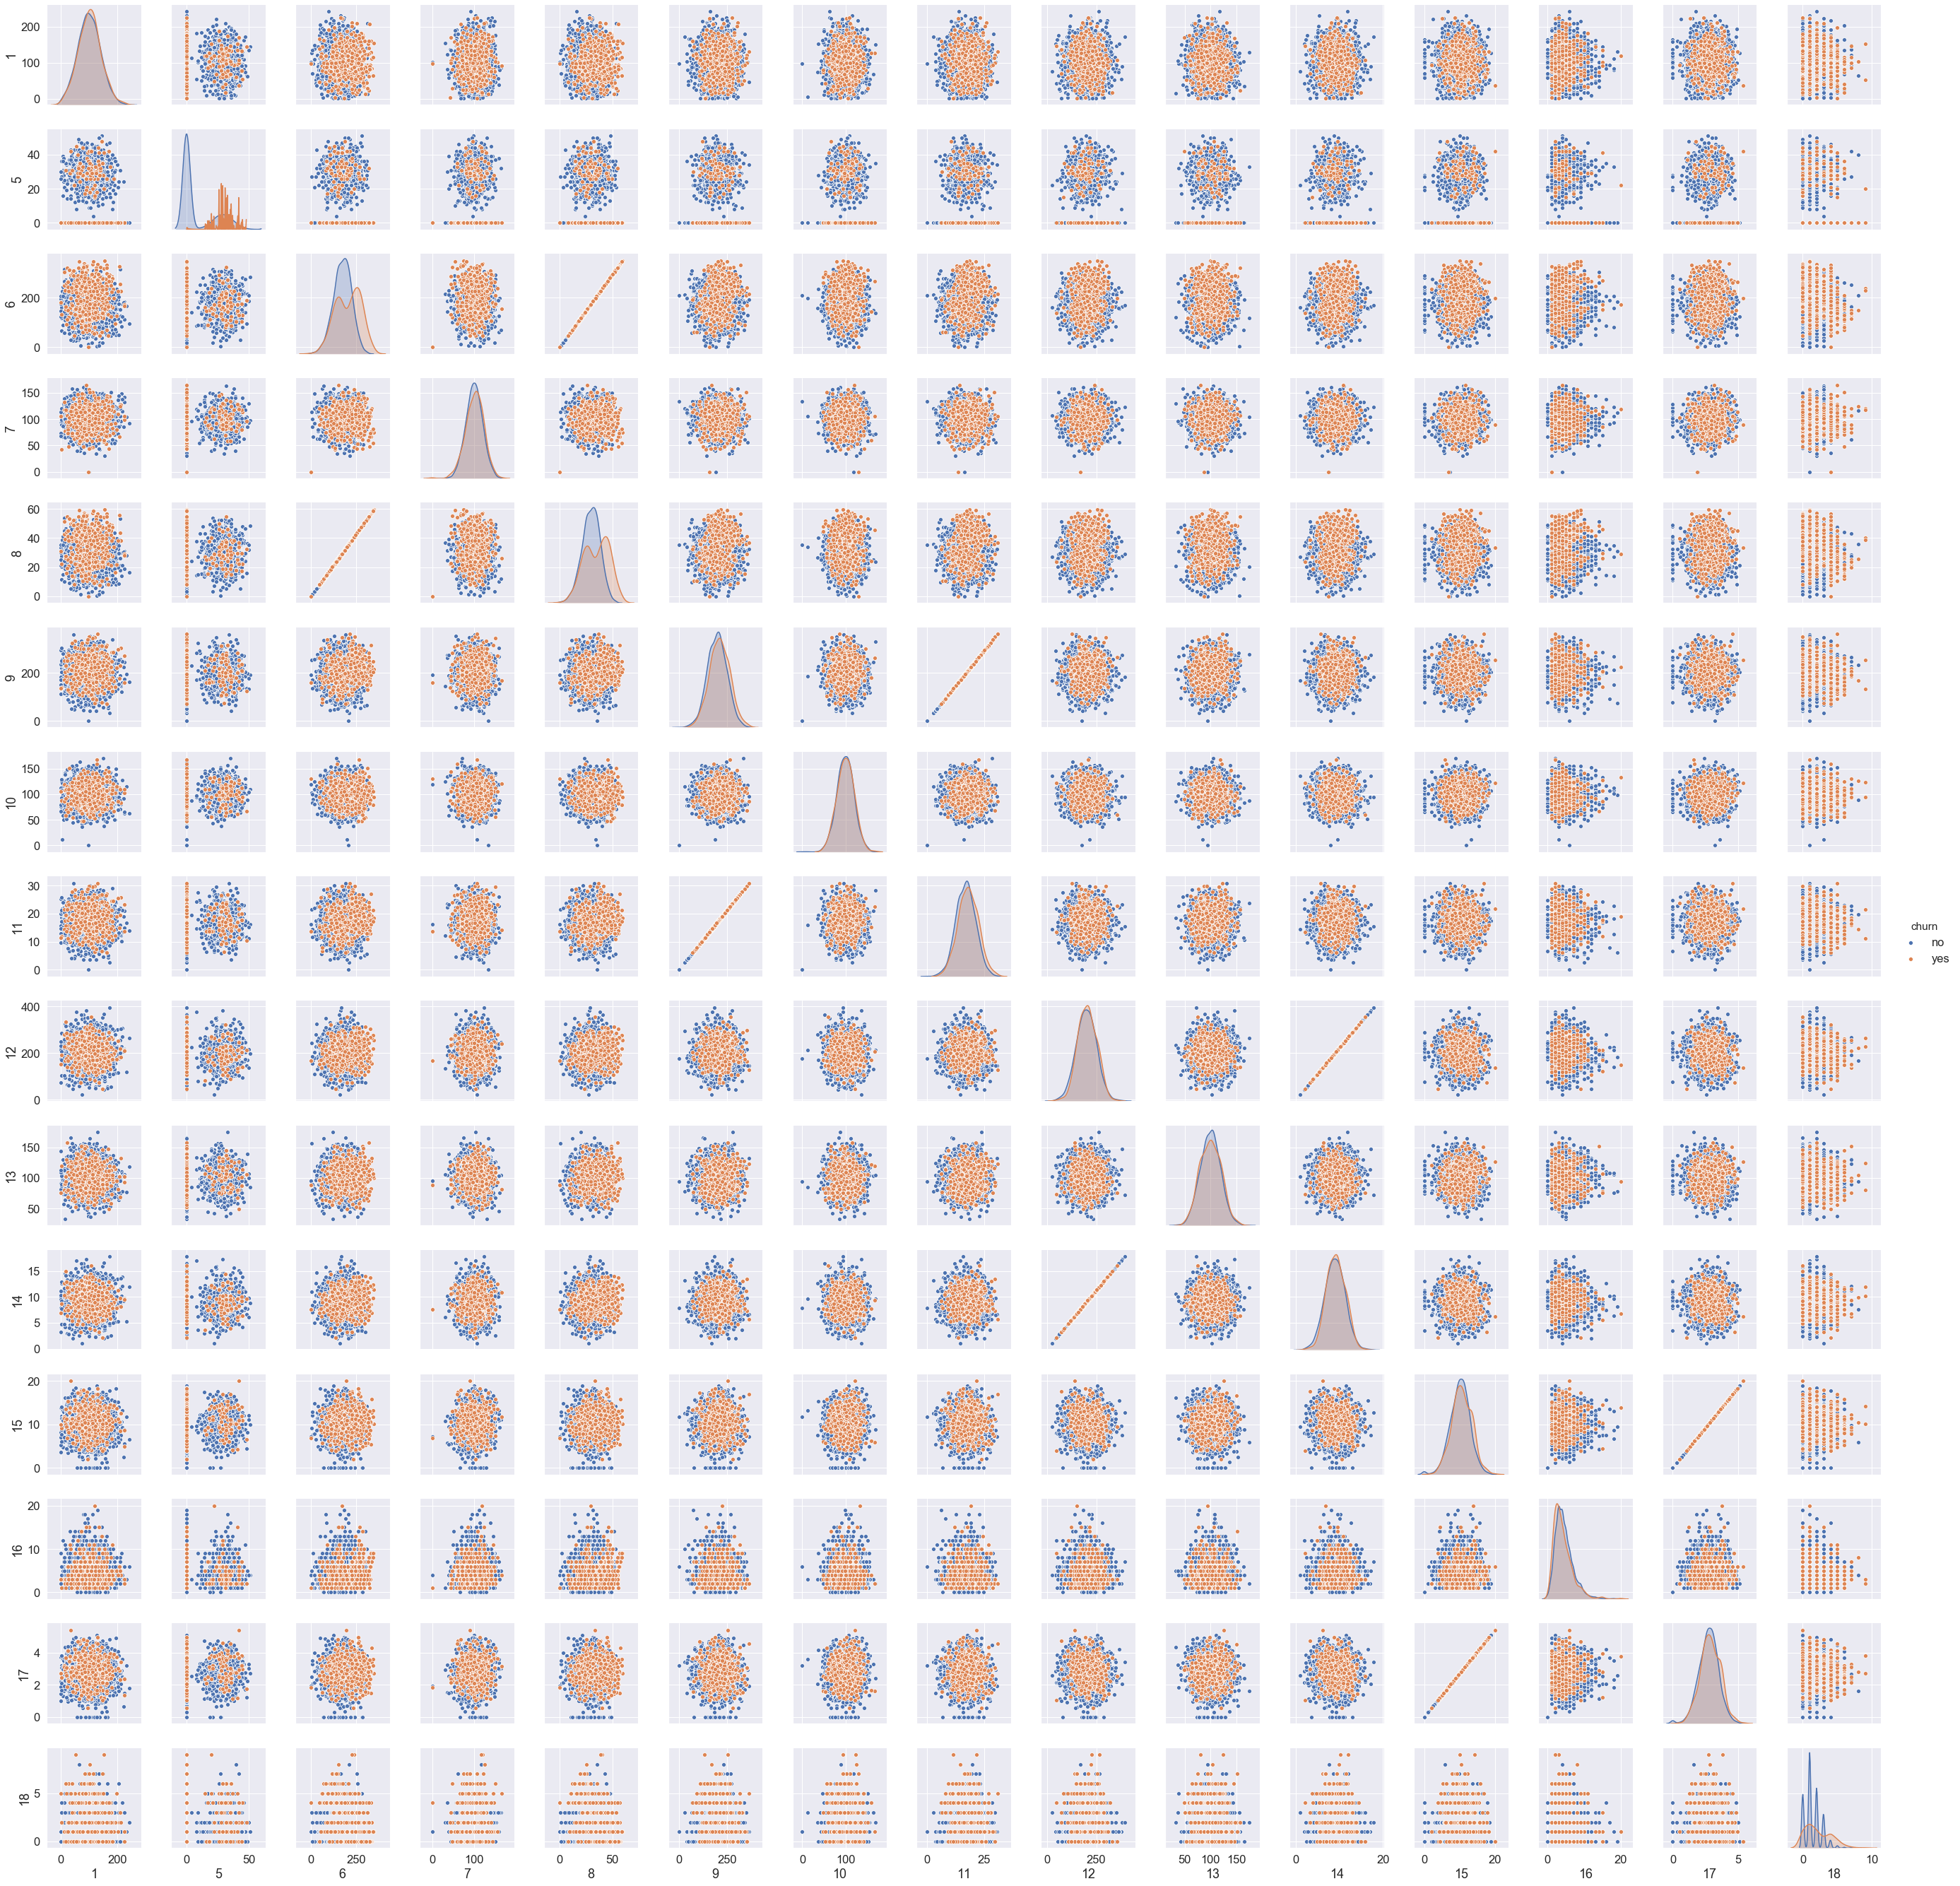

In [55]:
#Usando a função pairs do pacote seaborn para dar uma olhada na distribuição das variáveis numéricas
sns.set(font_scale=1.5)
sns.pairplot(treino.rename(columns = mapeamento),hue = 'churn')

É notavel, tanto pelo gráfico de dispersão, tanto pelo mapa de correlação (agora ainda mais evidente) que existe uma dependencia linear entre algumas variáveis, sempre respeitando:

__**_charge*__ e __**_minutes*__

Por isso, <font color = blue> podemos remover um dos pares </font>, para faciliar a modelagem e não permitir dependência linear entre elas

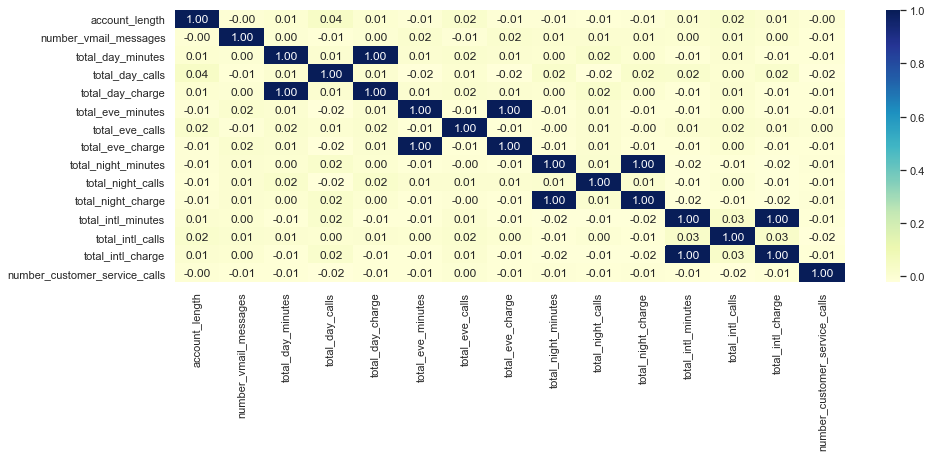

In [48]:
#Analisando a correlação entre as variáveis
plt.subplots(figsize=(15,5))
sns.heatmap(treino.corr(), annot=True, fmt=".2f",cmap="YlGnBu")

## Transformação de variáveis

In [25]:
#Convertendo as variáveis booleanas
variaveis_booleanas = ['international_plan','churn','voice_mail_plan']
treino.loc[:,variaveis_booleanas] = treino.loc[:,variaveis_booleanas].applymap(lambda x: True if x == 'yes' else False)
treino

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,area_code_415,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,area_code_415,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,area_code_415,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,area_code_408,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,area_code_415,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,area_code_415,False,True,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,area_code_415,False,False,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,area_code_510,False,False,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,area_code_510,True,False,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [ ]:
#